Logs:  

[2023/09/05]
- Implementation of ARMA(p, q) 
  `from statsmodesl.tsa.arima_model import ARMA, ARIMA`
  is deprecated. Use SARIMAX

In [41]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib as mpl
import pandas as pd
import itertools as itertls

from tqdm import notebook
from typing import Union

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.graphics.gofplots import qqplot
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima_process import ArmaProcess

from sklearn.metrics import mean_squared_error, mean_absolute_error, \
                            mean_absolute_percentage_error


In [2]:
plt.rcParams.update(plt.rcParamsDefault)
plt.rcParams.update({
  "font.size": 16,
  "grid.alpha": 0.25})

**Function declarations**

In [3]:
def plot_time_series(x, y, xlabel="Time", ylabel="Value", figsize=(10, 4), 
                     use_date_locator=True, title=None):
  fig, ax = plt.subplots(figsize=figsize)

  ax.plot(x, y)

  if use_date_locator:
    formatter = mdates.DateFormatter("%Y-%b")
    # locator = mdates.YearLocator(base=2)
    locator = mdates.MonthLocator(bymonthday=1, bymonth=range(1, 13, 2))
    ax.xaxis.set_major_formatter(formatter)
    ax.xaxis.set_major_locator(locator)
  

  ax.grid("on")
  ax.set_xlabel(xlabel)
  ax.set_ylabel(ylabel)

  if title is not None:
    ax.set_title(title)

  if use_date_locator:
    for j, label in enumerate(ax.get_xticklabels()):
      label.set_rotation(40)
      label.set_horizontalalignment('right')

  plt.show(fig)

When we have a time serie where you cannot infer an order 
from the ACF plot or from the PACF plot because both
figures exhibit a slowly decaying pattern or a
sinusoidal patter, we are in the presence of an autoregressive moving average (ARMA) process.

_Akaike information criterion_ (AIC) will 
determine the optimal combination of $p$ and $q$ 
of our series

We must evaluate the model's validity using residual 
analysis by studying the correlogram, Q-Q plot, 
and the density plot of the model's residuals to assess
if they closely resemble white noise.

## 6.1 Forecasting bandwidth usage for data centers

Suppose that you are tasked with predicting bandwidth
usage for a large data center so that it allows 
data centers to better manage their computing resources.

In [4]:
file_path = "./datasets/bandwidth_with_date.csv"
df_bandwidth = pd.read_csv(file_path, parse_dates=[0])
df_bandwidth

,date,hourly_bandwidth
0,2019-01-01 00:00:00,1000.496714
1,2019-01-01 01:00:00,1000.969408
2,2019-01-01 02:00:00,1002.046019
3,2019-01-01 03:00:00,1004.702118
4,2019-01-01 04:00:00,1007.447816
...,...,...
9995,2020-02-21 11:00:00,740.546059
9996,2020-02-21 12:00:00,738.906228
9997,2020-02-21 13:00:00,736.057995
9998,2020-02-21 14:00:00,733.559640


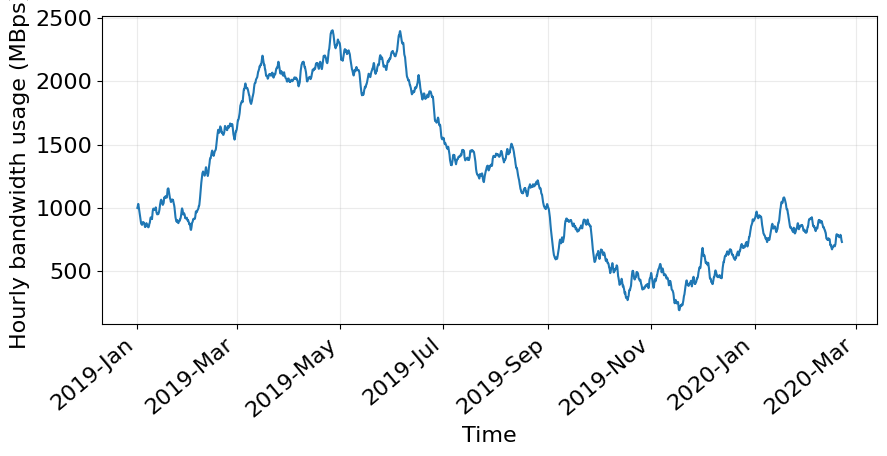

In [5]:
plot_time_series(df_bandwidth["date"], df_bandwidth["hourly_bandwidth"], 
                 ylabel="Hourly bandwidth usage (MBps)")

In order to forecast bandwidth usage, we step-by-step follow the below
procedures:
1. Collect data (it is already done in `bandwidth_with_date.csv`)
2. Determine if our series is stationary or not 
   - Use ADF test (calculate ADF statistic and $p$-value)
   - Apply transformation, recompute ADF statistic and $p$-value
3. Plot ACF to determine random walk or not
   - If the coefficients become abruptly non-significant
     after lag $q$, we have moving average process and stop.   
     If it is not the case, continue 
4. Plot PACF to determine autoregressive process or not
   - If the coefficients become abruptly non-significant
     after lag $p$, we have autoregressive process and stop.
     If it is not the case, we have combination of 
     moving average and autoregressive process.


## 6.2 Examining the autoregressive moving average process

**Autoregressive moving average process**    
The autoregressive moving average process is a combination
of the autoregressive process and the moving average process.

It is denoted as $\text{ARMA}(p,q)$, where $p$ is the order of 
the autoregressive process, and $q$ is the order of the moving 
average process. The general equaton of the $\text{ARMA}(p,q)$
model is
$$
  y_t = C  + \phi_1 y_{t-1} + \phi_2 y_{t-2} + \ldots + \phi_p y_{t-p}
        + \mu + \epsilon_t + \theta_1 \epsilon_{t-1}
          + \theta_2 \epsilon_{t-2} + \ldots + \theta_q \epsilon_{t-q}
$$

An $\text{ARMA}(0, q)$ process is equivalent to an $\text{MA}(q)$
process, since the order $p=0$ cancels the $\text{AR}(p)$ portion.
An $\text{ARMA}(p, 0)$ process is equivalent to an 
$\text{AR}(p)$ process, since the order $q = 0$ cancels 
the $\text{MA}(q)$ portion.

## 6.3 Identifying a stationary ARMA process

An extension step-by-step to determine the model of $\text{ARMA}(p,q)$

<img src="./figures/identify-stationary-order-arma.drawio.png" width=1000>

Let us simuate ARMA process before we apply ARMA model to forecast
bandwidth usage

Our $\text{ARMA}(1, 1)$ model is governed by the following equation:
$$
  y_t = 0.33 y_{t-1} + 0.9 \epsilon_{t-1} + \epsilon_t
$$

Then using that equation, we generate $1,000$ samples

In [6]:
# seed = 20230912     # non-invertible and non-stationary for MA = 1 or 2
seed = 20230918      # (p_max, q_max) = (3, 2)
rng = np.random.default_rng(seed)
distrvs = lambda size: rng.standard_normal(size)

ma1_coeff = np.array([1, 0.9])
ar1_coeff = np.array([1, -0.33])

arma_1_1_process = ArmaProcess(ar1_coeff, ma1_coeff)\
    .generate_sample(nsample=1000, distrvs=distrvs)

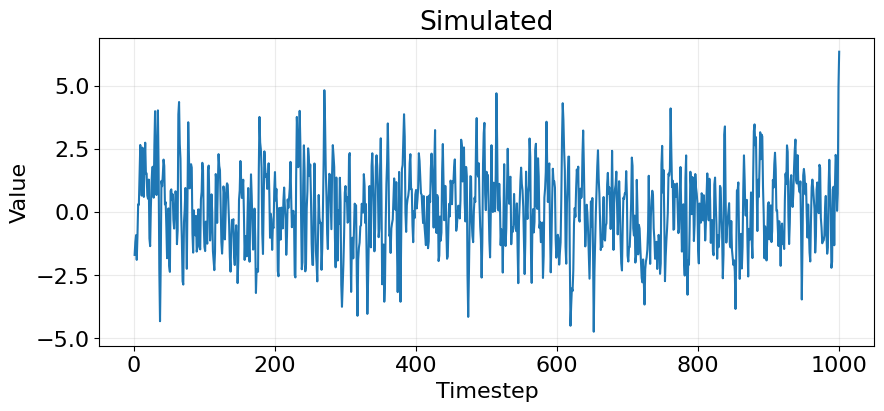

In [7]:
plot_time_series(np.arange(1, 1001), arma_1_1_process, 
                 ylabel="Value", xlabel="Timestep", use_date_locator=False,
                 title="Simulated")

With our simulated data ready, we can move on the next
step and verify whether our process is stationary or not.

In [8]:
ADF_result = adfuller(arma_1_1_process)
print(f"ADF statistic: {ADF_result[0]}")
print(f"p-value: {ADF_result[1]}")

ADF statistic: -5.79466269139562
p-value: 4.782890776853743e-07


Since we have a large negative ADF statistic and $p$-value that's
much smaller than $0.05$, we can conclude that our simulated 
$\text{ARMA}(1,1)$ process is stationary

The next step by plotting ACF plot whether we can infer the 
order of moving average proceess or not

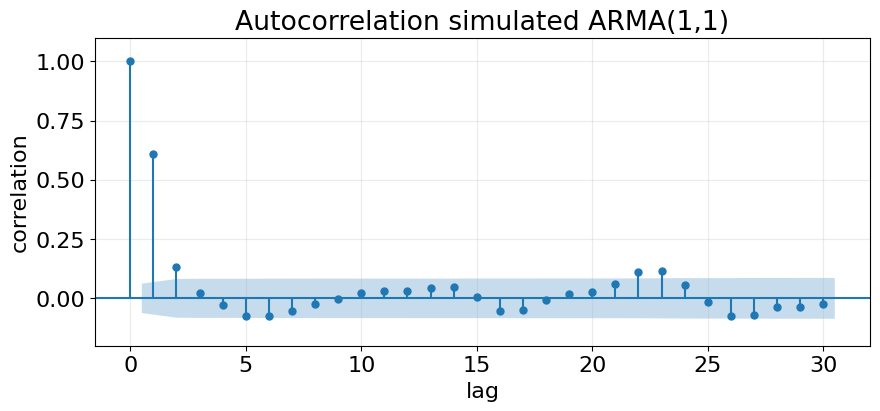

In [9]:
fig, ax = plt.subplots(figsize=(10, 4))

fig = plot_acf(arma_1_1_process, lags=30, ax=ax)

ax.set_ylim([-.2, 1.1])
ax.set_ylabel("correlation")
ax.set_xlabel("lag")
ax.set_title("Autocorrelation simulated ARMA(1,1)")
ax.grid("on")

plt.show(fig)

We notice from the above plot that last significant
coefficient is at lag 2. However, we know that our
simulted data has an $\text{MA}(1)$ process, so we would expect
to have significant coefficients up to lag 1 only. 

We can thus conclude that the ACF plot does not reveal any
useful information about the order $q$ of our $\text{ARMA}(1,1)$
process.

Now we move on the next step and use plot PACF

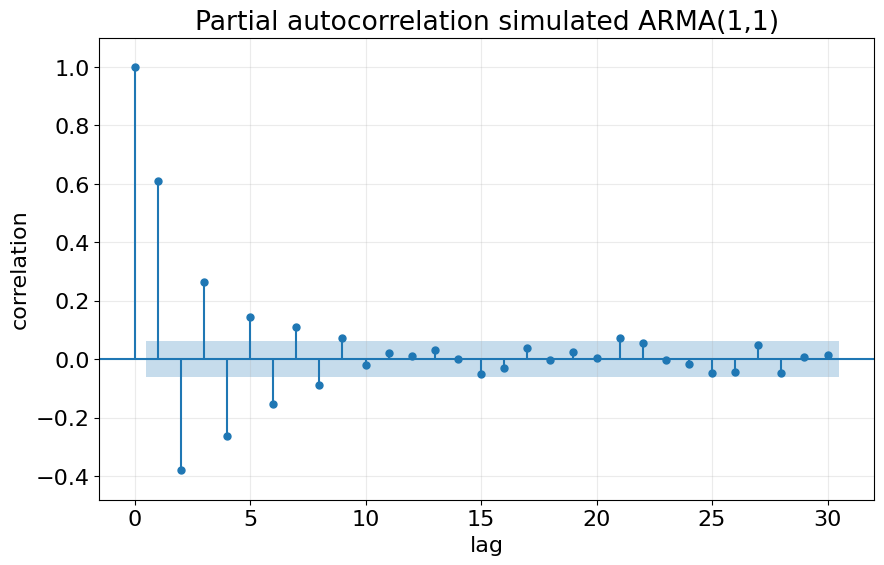

In [10]:
fig, ax = plt.subplots(figsize=(10, 6))

fig = plot_pacf(arma_1_1_process, lags=30, ax=ax)

ax.set_ylim([-.48, 1.1])
ax.set_ylabel("correlation")
ax.set_xlabel("lag")
ax.set_title("Partial autocorrelation simulated ARMA(1,1)")
ax.grid("on")

plt.show(fig)


We can clearly see from the plot that te correlations past lag 1.
Another feature is we do not have abruptly changes in correlations
and we easily notice a sinusoidal pattern.

We know that we simulated an $\text{ARMA}(1, 1)$ so the PACF plot
cannot be used to find the order $p$ of an $\text{ARMA}(p,q)$
process.

**Identifying a statonary $\text{ARMA}(p,q)$ process**    
If your process is stationary and both the ACF and PACF plots
show a decayig or sinusoidal pattern, then it is a stationar
$\text{ARMA}(p,q)$ process.

## 6.4 Devising a general modeling procedure

Our general strategy to determine the order of ARMA process
should not depend on qualitative plot of ACF and PACF.    
The following strategy is based entirely on statistical tests
and numerical criteria

<img src="./figures/identify-stationary-general-procedure-arma.drawio.png" width=600>

**Akaike information criterion** (AIC)    
The Akaike information criterion (AIC) is a measure of the quality of a model
in relation to other models. It is used for model selection.

The AIC is a function of the number of parameters $k$ in a model and the maximum
value of the likelihood function $\hat{L}$
$$
  \text{AIC} = 2k - 2 \ln(\hat{L})
$$

The lower the value of the AIC, the better the model. Selecting according
to the AIC allows us to keep a balance between the complexity of a model
and its goodness of fit to the data.

Given a model with fixed parameters, the distribution function will measure
the probability of observing a data point. The likelihood function
flips the logic. Given a set of observed data, it will estimate how likely
it is that different model parameters will generate the observed data.

We can think the AIC as a measure that keeps a balance between underfitting
and overfitting.
Underfitting means we have lower number of parameters (better AIC) but
likelihood will be poor because of small number of parameters will give us
a poor fit.

Overfitting means we have larger number of parameters (worse AIC) but
likelihood will have a very good fit because of the higher the number of parameters.

Now we continue to analyze our simulated ARMA process with the Akaike information
criterion.    
From ACF and PACF plot, we can allow the values of $p$ and $q$
to vary from $0$ to $3$.    
This range arbitrary, and you may try a larger
range of values if you wish.

In [11]:
p_space = range(0, 4, 1)
q_space = range(0, 3, 1)   # we we set range(0, 4, 1) we have ConvergenceWarning

order_list = list(itertls.product(p_space, q_space))
order_list

[(0, 0),
 (0, 1),
 (0, 2),
 (1, 0),
 (1, 1),
 (1, 2),
 (2, 0),
 (2, 1),
 (2, 2),
 (3, 0),
 (3, 1),
 (3, 2)]

 We use the term **endogenous** and **exogeneous**:
 - endogenous: caused by factors within the system
 - exogeneous: caused by factors outside the systems

 For the detail and example see: [`endog`, `exog`, what's that?](https://www.statsmodels.org/stable/endog_exog.html)

In [12]:
def optimize_ARMA(endog: Union[pd.Series, list], order_list: list) -> pd.DataFrame:

  result = []

  for order in notebook.tqdm(order_list):
    try:
      model = SARIMAX(endog, order=(order[0], 0, order[1]), 
                      simple_differencing=False).fit(disp=False)
    except:
      continue 

    aic = model.aic
    result.append([order, aic])

  
  result_df = pd.DataFrame(result)
  # print(result_df.columns)
  result_df.columns = ["(p,q)", "AIC"]

  # Sort in ascending order, lower AIC is better
  result_df = result_df.sort_values(by="AIC", ascending=True).reset_index(drop=True)

  return result_df

In [13]:
result_df = optimize_ARMA(arma_1_1_process, order_list)
result_df

  0%|          | 0/12 [00:00<?, ?it/s]

,"(p,q)",AIC
0,"(1, 1)",2887.339616
1,"(0, 2)",2887.871140
2,"(1, 2)",2888.819483
3,"(2, 1)",2888.914587
4,"(2, 2)",2890.306173
5,"(3, 1)",2890.551819
6,"(3, 2)",2892.307756
7,"(0, 1)",2943.259374
8,"(3, 0)",3068.485856
9,"(2, 0)",3141.585038


AIC is a measure of relative quality among many models.    
Residual anaysis is an absolute measure of model's quality.   

There are two aspects to residual analysis:
- a qualitative analysis    
  focus on studying the Q-Q plot
- a quantitative analysis    
  focus on the determination of the residuals are correlated or not

**Quantile-quantile plot (Q-Q plot)**    
A Q-Q plot is a plot of the quantiles of two distributions against each other.    
In time series forecasting, we plot the distribution of our residuals on the  
$y$-axis agains the theoretical normal distribution on the $x$-axis.

This graphical tool allows to us to assess the goodness of fit of our model.  
If the distribution of our residuals is similar to a normal distribution,  
we will see a straight line lying on $y = x$. This means that our model is a good  
fit, because the residuals are similar to white noise.

On the other hand, if the distribution of our residuals is different from a normal  
distribution, we will see a curved line. We can then conclude that our model  
is not a good fit, since the residuals' distributions is not close to a normal  
distribution, and therefore the residuals are not similar to white noise.

**Ljung-Box test**  
The Ljung-Box test is a statistical test that determines whether the autocorrelation  
of a group of data is significantly different from 0.

In time series forecasting, we apply the Ljung-Box test on the model's residuals  
to test whether they are similar to white noise. The null hypothesis states that  
the data is independently distributed, meaning that there is no autocorrelation.  
If the $p$-value is larger than 0.05, we cannot reject the null hypothesis, meaning  
that the residuals are independently distributed. Therefore, there is no autocorrelation,  
the residuals are similar to white noise, and the model can be used for forecasting.

Now we move to the next step in our general procedures to perform residual  
analysis to assess whether our model is a good fit to the data. From the  
previous result we have found that the best orders for $p$ and $q$ with
the lowes AIC coefficients is (1, 1).

In [21]:
model_lowest_aic = SARIMAX(arma_1_1_process, order=(1, 0, 1), 
                          simple_differencing=False)
model_lowest_aic_fit = model_lowest_aic.fit(disp=False)
residuals = model_lowest_AIC_fit.resid

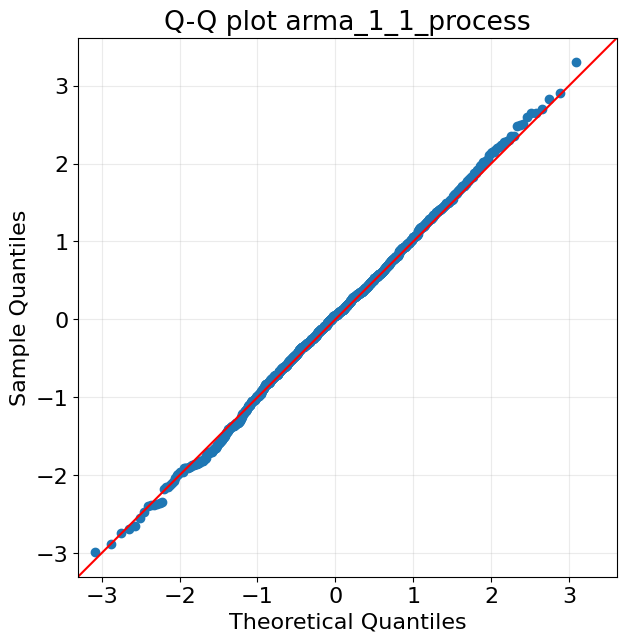

In [37]:
fig, ax = plt.subplots(figsize=(7, 7))
qqplot(residuals, line='45', ax=ax)
ax.grid("on")
ax.set_aspect("equal")
ax.set_title("Q-Q plot arma_1_1_process")
plt.show(fig)

We can extend our qualitative analysis by using the `plot_diagnostics` methods.  
This generates a figure containing four different plots, including a Q-Q plot.

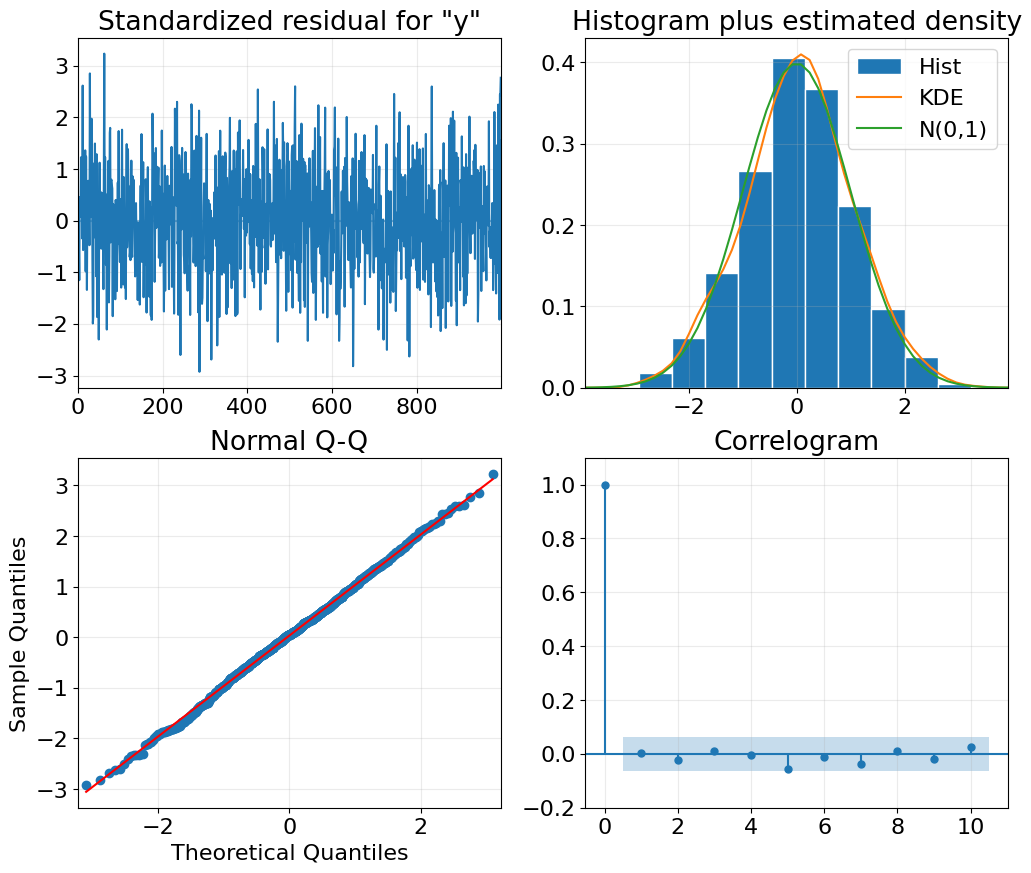

In [49]:
fig = plot_diagnostics = model_lowest_AIC_fit.plot_diagnostics(figsize=(12, 10))

# get all axes
axs = fig.get_axes()
for ax in axs:
  ax.grid("on")

# set y-lim for correlogram plot
axs[3].set_ylim([-0.2, 1.1])
plt.show(fig)

The final step in residual analysis is applying the Ljung-Box test.  
This allows us to quantitatively assess whether our residuals are indeed uncorrelated.  
We compute the Ljung-Box statistic and $p$-value for 10 lags.

In [53]:
ljung_box_test = acorr_ljungbox(residuals, np.arange(1, 11, 1))

ljung_box_test

,lb_stat,lb_pvalue
1,0.017564,0.894567
2,0.480077,0.786598
3,0.651807,0.884477
4,0.685493,0.953106
5,3.797442,0.578932
6,3.953003,0.683037
7,5.339002,0.618667
8,5.424513,0.711388
9,5.851727,0.754661
10,6.477431,0.773685


 The resulting list of $p$-values shows that each is aboe 0.05 (along the column `lb_pvalue`).  
 Therefore, at each lag, the null hypothesis cannot be rejected, meaning that  
 the residuals are independently distributed and uncorrelated.

## 6.5 Applying the general modeling procedure

Now, we apply the general modeling procedure to the bandwidth dataset.

In [54]:
file_path = "./datasets/bandwidth_with_date.csv"
df_bandwidth = pd.read_csv(file_path, parse_dates=[0])
df_bandwidth

,date,hourly_bandwidth
0,2019-01-01 00:00:00,1000.496714
1,2019-01-01 01:00:00,1000.969408
2,2019-01-01 02:00:00,1002.046019
3,2019-01-01 03:00:00,1004.702118
4,2019-01-01 04:00:00,1007.447816
...,...,...
9995,2020-02-21 11:00:00,740.546059
9996,2020-02-21 12:00:00,738.906228
9997,2020-02-21 13:00:00,736.057995
9998,2020-02-21 14:00:00,733.559640


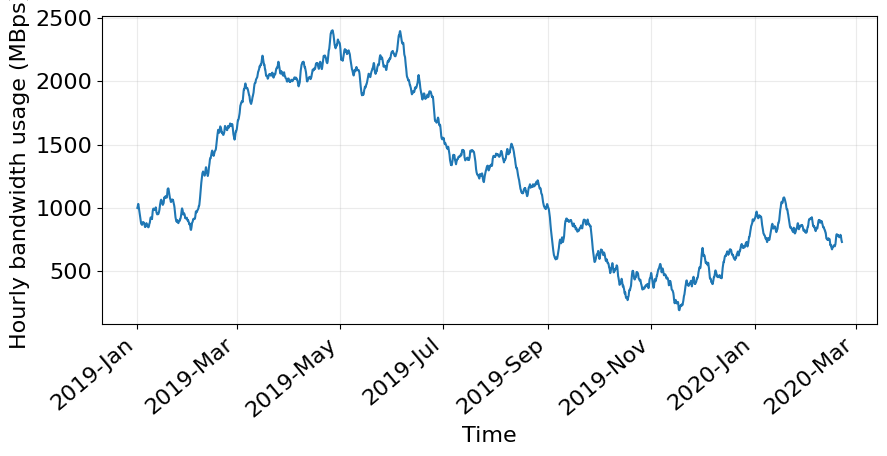

In [55]:
plot_time_series(df_bandwidth["date"], df_bandwidth["hourly_bandwidth"], 
                 ylabel="Hourly bandwidth usage (MBps)")

Our data is likely not stationary. Let's apply the ADF test to verify our hypothesis.

In [56]:
ADF_result = adfuller(df_bandwidth['hourly_bandwidth'])
print(f"ADF statistic: {ADF_result[0]}")
print(F"p-value: {ADF_result[1]}")

ADF statistic: -0.8714653199452532
p-value: 0.7972240255014615


The $p$-value is larger than 0.05. Therefore, we cannot reject the null hypothesis,  
meaning that our time series is not stationary. Because our time series is not stationary,  
we must apply a transformation. The simplest transformation is _first-order differencing_

In [58]:
bandwidth_diff = np.diff(df_bandwidth["hourly_bandwidth"], n=1)

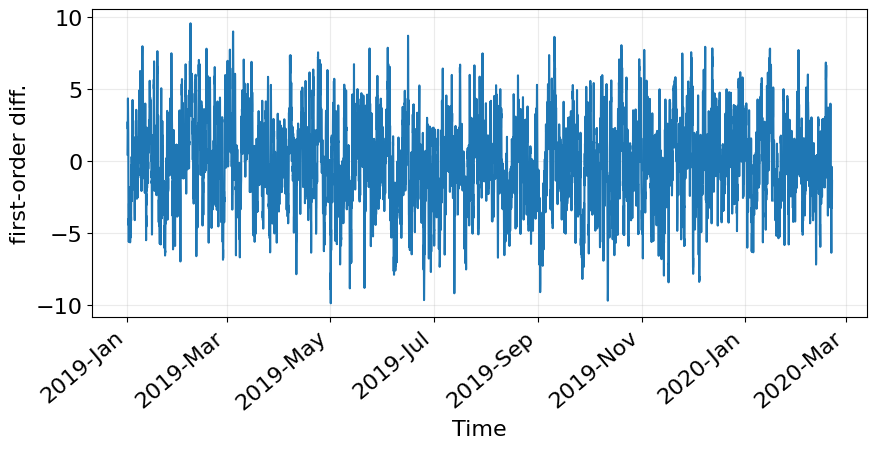

In [59]:
plot_time_series(df_bandwidth["date"][1:], bandwidth_diff, 
                 ylabel="first-order diff.")

We can apply the ADF test again to this differenced data

In [60]:
ADF_result = adfuller(bandwidth_diff)
print(f"ADF statistic: {ADF_result[0]}")
print(F"p-value: {ADF_result[1]}")

ADF statistic: -20.694853863789042
p-value: 0.0


With a large and negative ADF statistic and a $p$-value that is much smaller than  
0.04, we can say that our differenced series is stationary.

We are now ready to start modeling our stationary process using an $\text{ARMA}(p, q)$ model.  
We split our seies into train and test sets.  
Here we keep the last 7 days of data for the test set. We set our forecast for  
the next 2 hours, the test set thus contains 84 periods of 2 hours on which to  
evaluate our models' performance, since 7 days of hourly data totals 168 hours.

In [62]:
df_bandwidth_diff = pd.DataFrame({
  "date": df_bandwidth["date"][1:],
  "bandwidth_diff": bandwidth_diff })

df_train = df_bandwidth_diff[:-168]    # 7 days consists of 168 hours
df_test = df_bandwidth_diff[-168:]

print(f"(len(df_train), len(df_test)): {len(df_train), len(df_test)}")

(len(df_train), len(df_test)): (9831, 168)


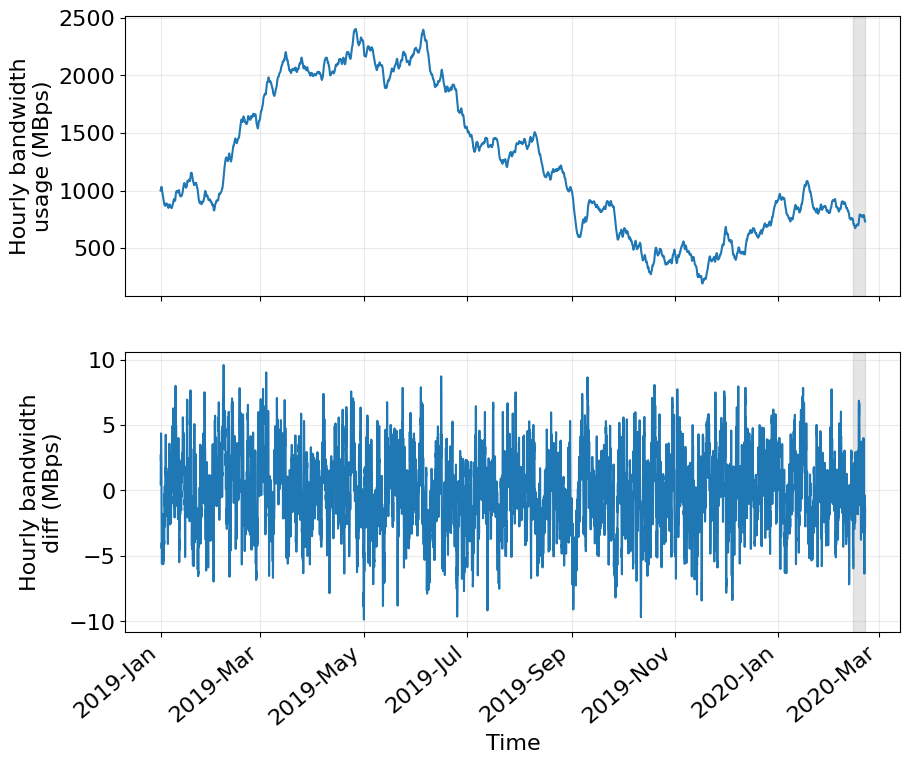

In [67]:
fig, axes = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=(10, 8))

# -- first row
axes[0].plot(df_bandwidth['date'], df_bandwidth["hourly_bandwidth"])
axes[0].grid("on")
axes[0].set_ylabel("Hourly bandwidth\nusage (MBps)")

# formatter = mdates.DateFormatter("%Y")
formatter = mdates.DateFormatter("%Y-%b")
# locator = mdates.YearLocator(base=2)
locator = mdates.MonthLocator(bymonthday=1, bymonth=range(1, 13, 2))
axes[0].xaxis.set_major_formatter(formatter)
axes[0].xaxis.set_major_locator(locator)

# -- second row
axes[1].plot(df_train["date"], df_train["bandwidth_diff"])
axes[1].plot(df_test["date"], df_test["bandwidth_diff"], color="tab:blue")
axes[1].set_xlabel("Time")
axes[1].set_ylabel("Hourly bandwidth\ndiff (MBps)")
axes[1].grid("on")

# add forecast area
for j in range(2):
  axes[j].axvspan(df_test['date'].iloc[0], df_test['date'].iloc[-1], 
                  color="#808080", alpha=0.2)

for j, label in enumerate(axes[1].get_xticklabels()):
  label.set_rotation(40)
  label.set_horizontalalignment('right')

plt.show(fig)

Now we ready to fit different $\text{ARMA}(p, q)$ models.  
Here we will tray values for $p$ and $q$ ranging frm 0 to 3 inclusively.

In [68]:
p_space = range(0, 4, 1)
q_space = range(0, 4, 1)

order_list = list(itertls.product(p_space, q_space))
order_list

[(0, 0),
 (0, 1),
 (0, 2),
 (0, 3),
 (1, 0),
 (1, 1),
 (1, 2),
 (1, 3),
 (2, 0),
 (2, 1),
 (2, 2),
 (2, 3),
 (3, 0),
 (3, 1),
 (3, 2),
 (3, 3)]

In [69]:
result_df = optimize_ARMA(df_train["bandwidth_diff"], order_list)
result_df

  0%|          | 0/16 [00:00<?, ?it/s]

/home/henokh/miniconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/henokh/miniconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/henokh/miniconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


,"(p,q)",AIC
0,"(3, 2)",27991.063879
1,"(2, 3)",27991.287509
2,"(2, 2)",27991.603598
3,"(3, 3)",27993.416924
4,"(1, 3)",28003.349550
5,"(1, 2)",28051.351401
6,"(3, 1)",28071.155496
7,"(3, 0)",28095.618186
8,"(2, 1)",28097.250766
9,"(2, 0)",28098.407664


From the above table, the first three models all have an AIC of 27,991, with only  
slight differences. Therefore, we would argue that the $\text{ARMA}(2,2)$ model is  
the model that should be selected. Its AIC value is very close to the $\text{ARMA}(3,2)$  
and $\text{ARMA}(2,3)$ models, while being less complex, since it has four parameters  
$(p + q = 2 + 2 = 4)$ to be estimated instead of five.

Next, we perform residual analysis

In [72]:
model_arma_2_2 = SARIMAX(df_train["bandwidth_diff"], order=(2, 0, 2), 
                        simple_differencing=False)
model_arma_2_2_fit = model_arma_2_2.fit(disp=False)

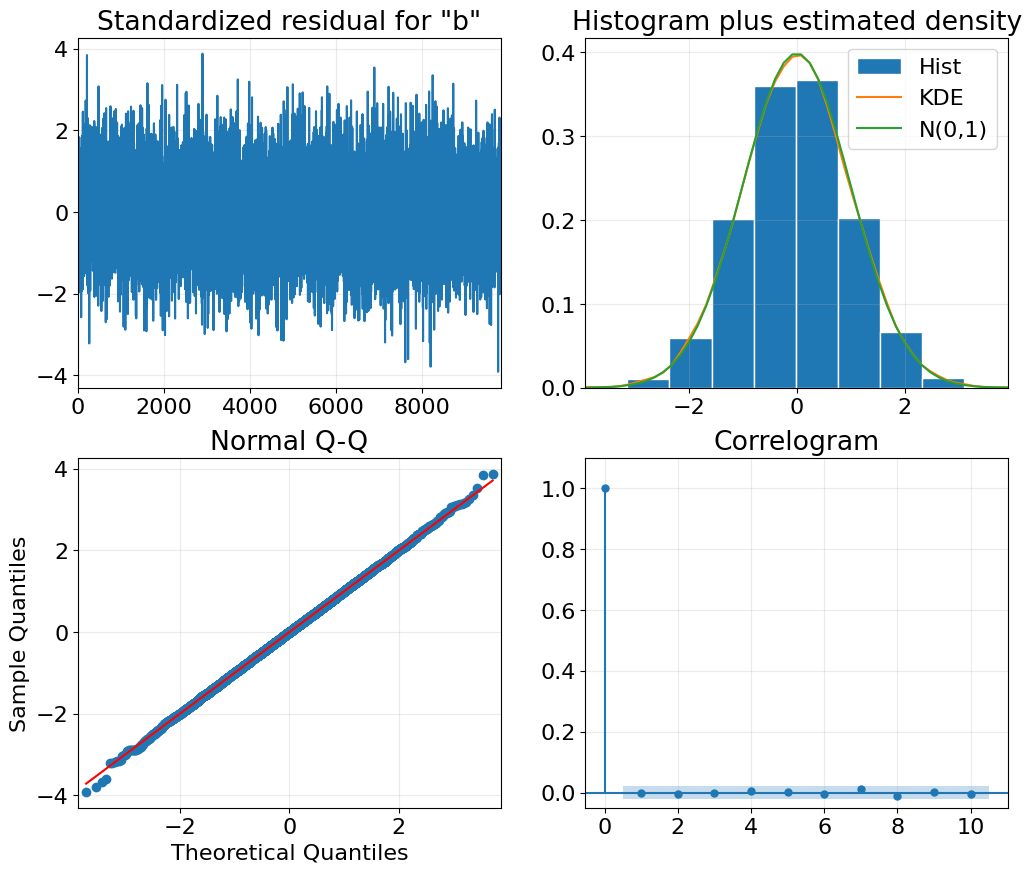

In [74]:
fig = plot_diagnostics = model_arma_2_2_fit.plot_diagnostics(figsize=(12, 10))

# get all axes
axs = fig.get_axes()
for ax in axs:
  ax.grid("on")

# set y-lim for correlogram plot
axs[3].set_ylim([-0.05, 1.1])
plt.show(fig)

From the figure above, we can see that:
1. top-left plot shows no trend, and the means seems constant over time, meaning  
   that our residuals are likely stationary.
2. top-right plot displays a density plot with a shape similar to that of a normal  
   distribution
3. bottom-left plot (Q-Q plot) shows a thick straight line that is very close  
   to $y = x$.
4. bottom-right plot shows no autocorrelation after lag 0.

Thus figure above indicates that our residuals clearly resemble white noise,  
since they are normally distributed and uncorrelated.

The last step is to run the Ljung-Box test on the residuals for the first 10 lags.

In [75]:
residuals = model_arma_2_2_fit.resid
ljung_box_test = acorr_ljungbox(residuals, np.arange(1, 11))
ljung_box_test

,lb_stat,lb_pvalue
1,0.042190,0.837257
2,0.418364,0.811247
3,0.520271,0.914416
4,0.850555,0.931545
5,0.850841,0.973678
6,1.111754,0.981019
7,2.124864,0.952607
8,3.230558,0.919067
9,3.248662,0.953615
10,3.588289,0.964015


All $p$-values have values greater than 0.05. Therefore, we can conclude that our  
residuals are indeed uncorrelated. Our $\text{ARMA}(2,2)$ model has passed all the  
checks on the residual analysis, and we are ready to use this model to forecast  
bandwidth usage.

## 6.6 Forecasting bandwidth usage

Now we will use the $\text{ARMA}(2,2)$ model to forecast the next 2 hours of bandwidth  
usage over 7 days. We also compare the model with naive model (mean and last value)

In [77]:
def rolling_forecast(df: pd.DataFrame, train_len: int, horizon: int, window: int, 
                      method: str, df_column_name: str, arma_order: tuple = None) -> list:
  """
  The following models using all the dataframe (train + test),
  because we roll out forecast with a correct data with the length
  of forecast is equal to `horizon`
  """
  total_len = train_len + horizon

  if method == "mean":
    pred_mean = []

    for i in range(train_len, total_len, window):
      mean = np.mean(df[:i][df_column_name])
      pred_mean.extend(mean for _ in range(window))

    return pred_mean

  elif method == "last":
    pred_last_value = []

    for i in range(train_len, total_len, window):
      last_value = df[:i][df_column_name].iloc[-1]
      pred_last_value.extend(last_value for _ in range(window))

    return pred_last_value

  elif method == "ARMA":
    pred_ARMA = []

    for i in range(train_len, total_len, window):
      model = SARIMAX(df[:i][df_column_name], order=arma_order)
      res = model.fit(disp=False)
      predictions = res.get_prediction(0, i + window - 1)
      oos_pred = predictions.predicted_mean.iloc[-window:]   # oos: output of sarimax
      pred_ARMA.extend(oos_pred)

    return pred_ARMA

In [78]:
# Approx time: 1 min 50 secs

df_test_pred = df_test.copy()

TRAIN_LEN = len(df_train)
HORIZON = len(df_test)
WINDOW = 2      # from the order of q in ARMA(2,2)

pred_mean = rolling_forecast(df_bandwidth_diff, TRAIN_LEN, HORIZON, WINDOW, 
                              "mean", "bandwidth_diff")
pred_last_value = rolling_forecast(df_bandwidth_diff, TRAIN_LEN, HORIZON, WINDOW, 
                                    "last", "bandwidth_diff")
pred_arma = rolling_forecast(df_bandwidth_diff, TRAIN_LEN, HORIZON, WINDOW, 
                              "ARMA", "bandwidth_diff", arma_order=(2, 0, 2))

df_test_pred["pred_mean"] = pred_mean
df_test_pred["pred_last_value"] = pred_last_value
df_test_pred["pred_arma"] = pred_arma

df_test_pred.head()

,date,bandwidth_diff,pred_mean,pred_last_value,pred_arma
9832,2020-02-14 16:00:00,-5.943995,-0.028214,-5.791207,-5.460661
9833,2020-02-14 17:00:00,-5.865194,-0.028214,-5.791207,-4.890626
9834,2020-02-14 18:00:00,-3.197066,-0.029410,-5.865194,-5.335905
9835,2020-02-14 19:00:00,-1.090197,-0.029410,-5.865194,-4.751731
9836,2020-02-14 20:00:00,0.665291,-0.029840,-1.090197,-0.375596


We can then plot and visualize the forecast for each method

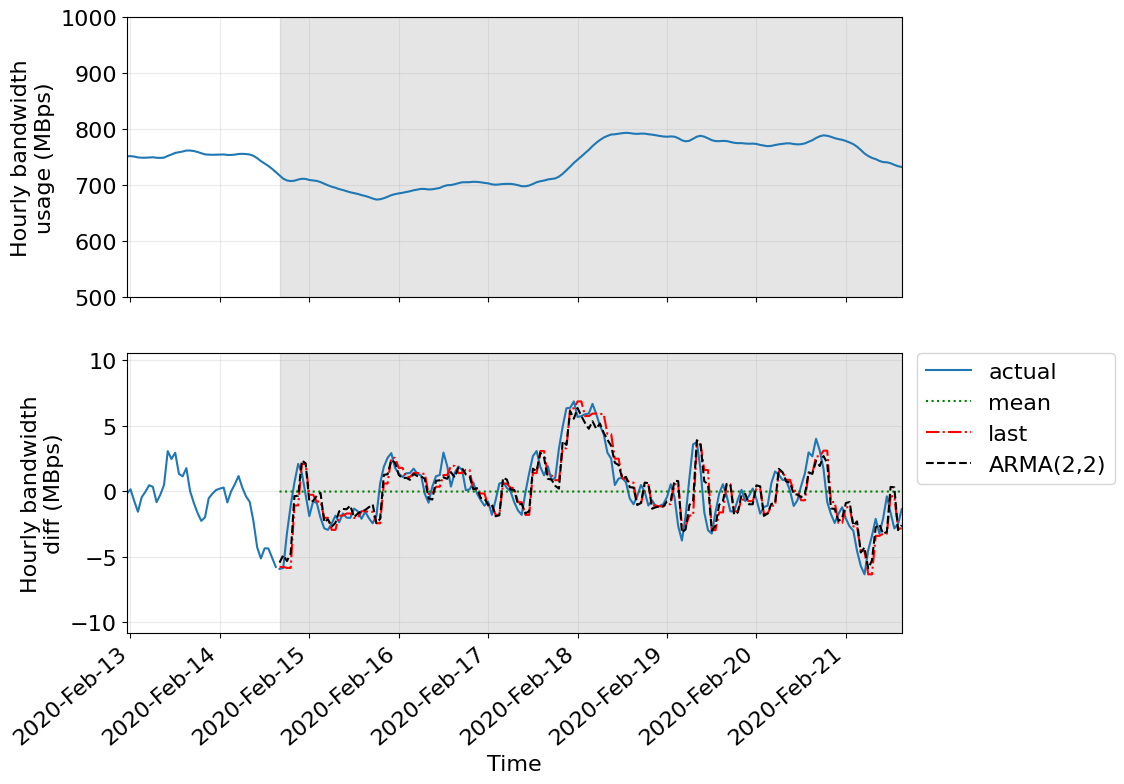

In [85]:
start_idx = 9790  # for better visualization
xlim = [df_train["date"].iloc[start_idx], df_test["date"].iloc[-1]]

fig, axes = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=(10, 8))

# -- first row
axes[0].plot(df_bandwidth['date'], df_bandwidth["hourly_bandwidth"])
formatter = mdates.DateFormatter("%Y-%b-%d")
# locator = mdates.YearLocator(base=2)
# locator = mdates.MonthLocator(bymonthday=1, bymonth=range(1, 13, 1))
locator = mdates.DayLocator()
axes[0].xaxis.set_major_formatter(formatter)
axes[0].xaxis.set_major_locator(locator)
axes[0].set_ylim([500, 1000])
axes[0].grid("on")
axes[0].set_ylabel("Hourly bandwidth\nusage (MBps)")
axes[0].set_xlim(xlim)

# -- second row
axes[1].plot(df_train["date"], df_train["bandwidth_diff"])
axes[1].plot(df_test["date"], df_test["bandwidth_diff"], color="tab:blue", label="actual")
axes[1].set_xlabel("Time")
axes[1].set_ylabel("Hourly bandwidth\ndiff (MBps)")
axes[1].grid("on")
# -- prediction
axes[1].plot(df_test_pred["date"], df_test_pred["pred_mean"], "g:", label="mean")
axes[1].plot(df_test_pred["date"], df_test_pred["pred_last_value"], "r-.", label="last")
axes[1].plot(df_test_pred["date"], df_test_pred["pred_arma"], "k--", label="ARMA(2,2)")

# add forecast area
for j in range(2):
  axes[j].axvspan(df_test['date'].iloc[0], df_test['date'].iloc[-1], 
                  color="#808080", alpha=0.2)

for j, label in enumerate(axes[1].get_xticklabels()):
  label.set_rotation(40)
  label.set_horizontalalignment('right')

# -- add legend in the second row
axes[1].legend(loc="upper left", bbox_to_anchor=[1.02, 1], borderaxespad=0.)

plt.show(fig)




Zoom in to the forecast area

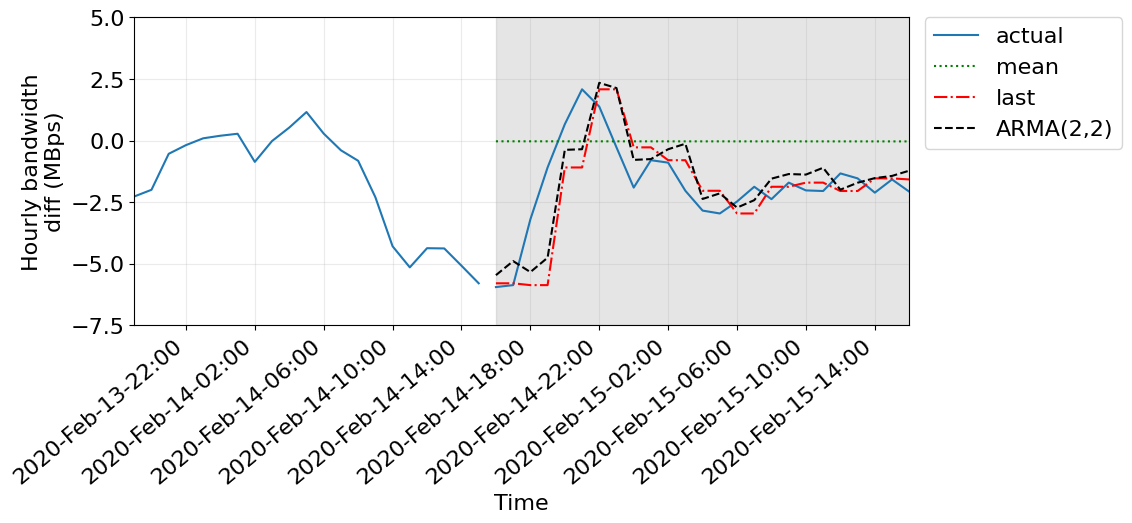

In [101]:
# choose your zoom-in area
start_idx = 9810 
stop_idx = 24   # two day 
ylim = [-7.5, 5]
xlim = [df_train["date"].iloc[start_idx], df_test["date"].iloc[stop_idx]]

fig, ax = plt.subplots(figsize=(10, 4))

# -- first row
formatter = mdates.DateFormatter("%Y-%b-%d-%H:00")
# locator = mdates.YearLocator(base=2)
# locator = mdates.MonthLocator(bymonthday=1, bymonth=range(1, 13, 1))
# locator = mdates.DayLocator()
locator = mdates.HourLocator(interval=4)
ax.xaxis.set_major_formatter(formatter)
ax.xaxis.set_major_locator(locator)
ax.grid("on")
ax.set_ylabel("Hourly bandwidth\ndiff (MBps)")
ax.set_xlim(xlim)
ax.set_ylim(ylim)

ax.plot(df_train["date"], df_train["bandwidth_diff"])
ax.plot(df_test["date"], df_test["bandwidth_diff"], color="tab:blue", label="actual")
ax.set_xlabel("Time")
ax.set_ylabel("Hourly bandwidth\ndiff (MBps)")
ax.grid("on")
# -- prediction
ax.plot(df_test_pred["date"], df_test_pred["pred_mean"], "g:", label="mean")
ax.plot(df_test_pred["date"], df_test_pred["pred_last_value"], "r-.", label="last")
ax.plot(df_test_pred["date"], df_test_pred["pred_arma"], "k--", label="ARMA(2,2)")

# add forecast area
ax.axvspan(df_test['date'].iloc[0], df_test['date'].iloc[-1], 
                  color="#808080", alpha=0.2)

for label in ax.get_xticklabels():
  label.set_rotation(40)
  label.set_horizontalalignment('right')

# -- add legend in the second row
ax.legend(loc="upper left", bbox_to_anchor=[1.02, 1], borderaxespad=0.)

plt.show(fig)

In [99]:
df_test_pred.head(12)

,date,bandwidth_diff,pred_mean,pred_last_value,pred_arma
9832,2020-02-14 16:00:00,-5.943995,-0.028214,-5.791207,-5.460661
9833,2020-02-14 17:00:00,-5.865194,-0.028214,-5.791207,-4.890626
9834,2020-02-14 18:00:00,-3.197066,-0.029410,-5.865194,-5.335905
9835,2020-02-14 19:00:00,-1.090197,-0.029410,-5.865194,-4.751731
9836,2020-02-14 20:00:00,0.665291,-0.029840,-1.090197,-0.375596
9837,2020-02-14 21:00:00,2.081711,-0.029840,-1.090197,-0.349673
9838,2020-02-14 22:00:00,1.379944,-0.029554,2.081711,2.344618
9839,2020-02-14 23:00:00,-0.274492,-0.029554,2.081711,2.132138
9840,2020-02-15 00:00:00,-1.907255,-0.029436,-0.274492,-0.782646
9841,2020-02-15 01:00:00,-0.795027,-0.029436,-0.274492,-0.749973


Now we measure the mean squared error (MSE) to evaluate the performance  
of each model.

In [102]:
mse_mean = mean_squared_error(df_test_pred["bandwidth_diff"], df_test_pred["pred_mean"])
mse_last = mean_squared_error(df_test_pred["bandwidth_diff"], df_test_pred["pred_last_value"])
mse_arma = mean_squared_error(df_test_pred["bandwidth_diff"], df_test_pred["pred_arma"])

print(f"MSE mean: {mse_mean}")
print(f"MSE last: {mse_last}")
print(f"MSE ARMA: {mse_arma}")

MSE mean: 6.306526957989325
MSE last: 2.2297582947733656
MSE ARMA: 1.7690462113908976


The $\text{ARMA}(2,2)$ model outperforms the benchmarks, meaning that we have  
a well-performing model.

The final step is to reverse the transformation of our forecast in order to bring  
it to the same scae as our original data.

Now we recover by inverse tranform of our prediction to bring them
back  to the original scale.

$$
\begin{align*}
  y'_1 = y_1 - y_0 \quad &\Rightarrow y_1 = y_0 + y'_1 \\
  y'_2 = y_2 - y_1 \quad &\Rightarrow y_2 = y_1 + y'_2 = (y_0 + y'_1) + y'_2 \\
  y'_3 = y_3 - y_2 \quad &\Rightarrow y_3 = y_2 + y'_3 = (y_1 + y'_2) + y'_3 = ((y_0 + y'_1) + y'_2) + y'_3 \\
  \vdots \\
  y'_N = y_N - y_{N-1} \quad &\Rightarrow 
    y_N = y_{N-1} + y'_N = (y_{N-2} + y'_{N-1}) + y'_N = \ldots 
        = y_0 + \sum_{t=1}^{N} y'_t
\end{align*}
$$


In [103]:
idx_y0 = len(df_train) + 1 
y0 = df_bandwidth.iloc[idx_y0]["hourly_bandwidth"]
# print(y0)
df_test_bandwidth = df_bandwidth[idx_y0:].copy()
df_test_bandwidth["pred_mean"]       = y0 + df_test_pred["pred_mean"].cumsum()
df_test_bandwidth["pred_last_value"] = y0 + df_test_pred["pred_last_value"].cumsum()
df_test_bandwidth["pred_arma"]       = y0 + df_test_pred["pred_arma"].cumsum()
df_test_bandwidth.head()

,date,hourly_bandwidth,pred_mean,pred_last_value,pred_arma
9832,2020-02-14 16:00:00,717.176939,717.148725,711.385732,711.716278
9833,2020-02-14 17:00:00,711.311745,717.120510,705.594526,706.825651
9834,2020-02-14 18:00:00,708.114679,717.091101,699.729332,701.489746
9835,2020-02-14 19:00:00,707.024482,717.061691,693.864137,696.738016
9836,2020-02-14 20:00:00,707.689774,717.031851,692.773941,696.362419


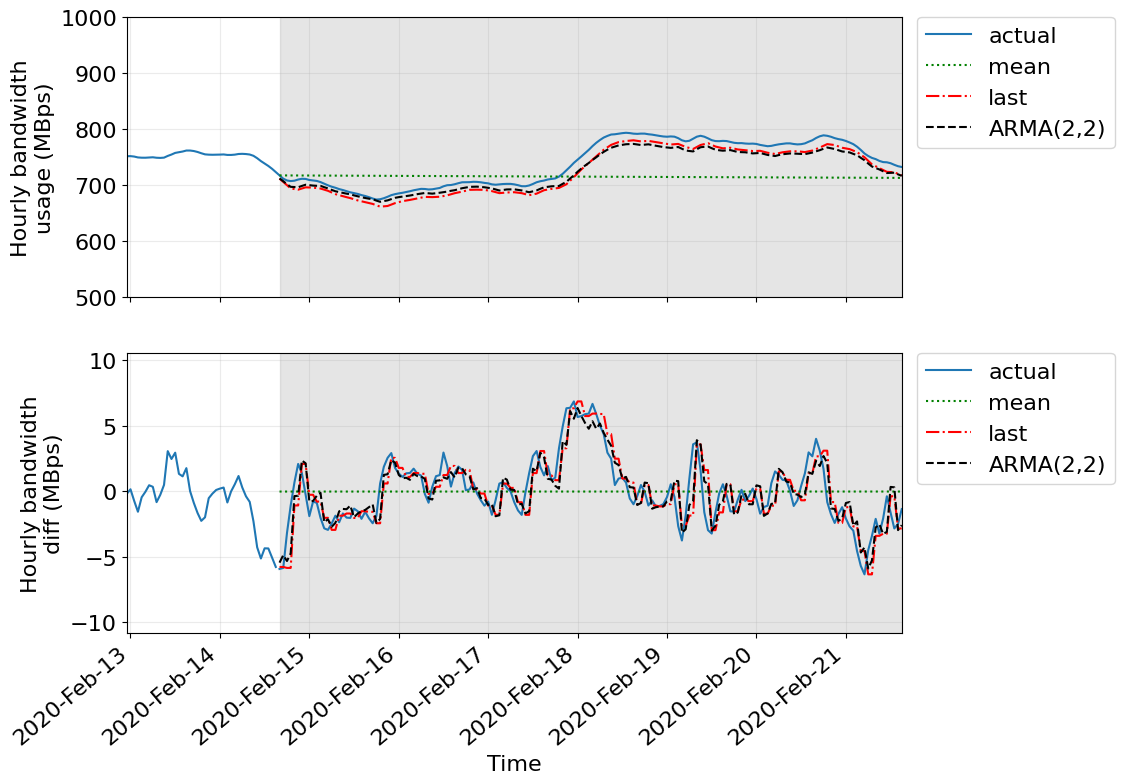

In [106]:
start_idx = 9790  # for better visualization
xlim = [df_train["date"].iloc[start_idx], df_test["date"].iloc[-1]]

fig, axes = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=(10, 8))

# -- first row
axes[0].plot(df_bandwidth['date'], df_bandwidth["hourly_bandwidth"], label="actual")
# -- prediction for the original data
axes[0].plot(df_test_bandwidth['date'], df_test_bandwidth["pred_mean"], "g:", label="mean")
axes[0].plot(df_test_bandwidth['date'], df_test_bandwidth["pred_last_value"], "r-.", label="last")
axes[0].plot(df_test_bandwidth['date'], df_test_bandwidth["pred_arma"], "k--", label="ARMA(2,2)")

formatter = mdates.DateFormatter("%Y-%b-%d")
# locator = mdates.YearLocator(base=2)
# locator = mdates.MonthLocator(bymonthday=1, bymonth=range(1, 13, 1))
locator = mdates.DayLocator()
axes[0].xaxis.set_major_formatter(formatter)
axes[0].xaxis.set_major_locator(locator)
axes[0].set_ylim([500, 1000])
axes[0].grid("on")
axes[0].set_ylabel("Hourly bandwidth\nusage (MBps)")
axes[0].set_xlim(xlim)
axes[0].set_ylim()
axes[0].legend(loc="upper left", bbox_to_anchor=[1.02, 1], borderaxespad=0.)

# -- second row
axes[1].plot(df_train["date"], df_train["bandwidth_diff"])
axes[1].plot(df_test["date"], df_test["bandwidth_diff"], color="tab:blue", label="actual")
# -- prediction
axes[1].plot(df_test_pred["date"], df_test_pred["pred_mean"], "g:", label="mean")
axes[1].plot(df_test_pred["date"], df_test_pred["pred_last_value"], "r-.", label="last")
axes[1].plot(df_test_pred["date"], df_test_pred["pred_arma"], "k--", label="ARMA(2,2)")

axes[1].set_xlabel("Time")
axes[1].set_ylabel("Hourly bandwidth\ndiff (MBps)")
axes[1].grid("on")
axes[1].legend(loc="upper left", bbox_to_anchor=[1.02, 1], borderaxespad=0.)

# add forecast area
for j in range(2):
  axes[j].axvspan(df_test['date'].iloc[0], df_test['date'].iloc[-1], 
                  color="#808080", alpha=0.2)

for j, label in enumerate(axes[1].get_xticklabels()):
  label.set_rotation(40)
  label.set_horizontalalignment('right')


plt.show(fig)

Zoom in to the forecast area

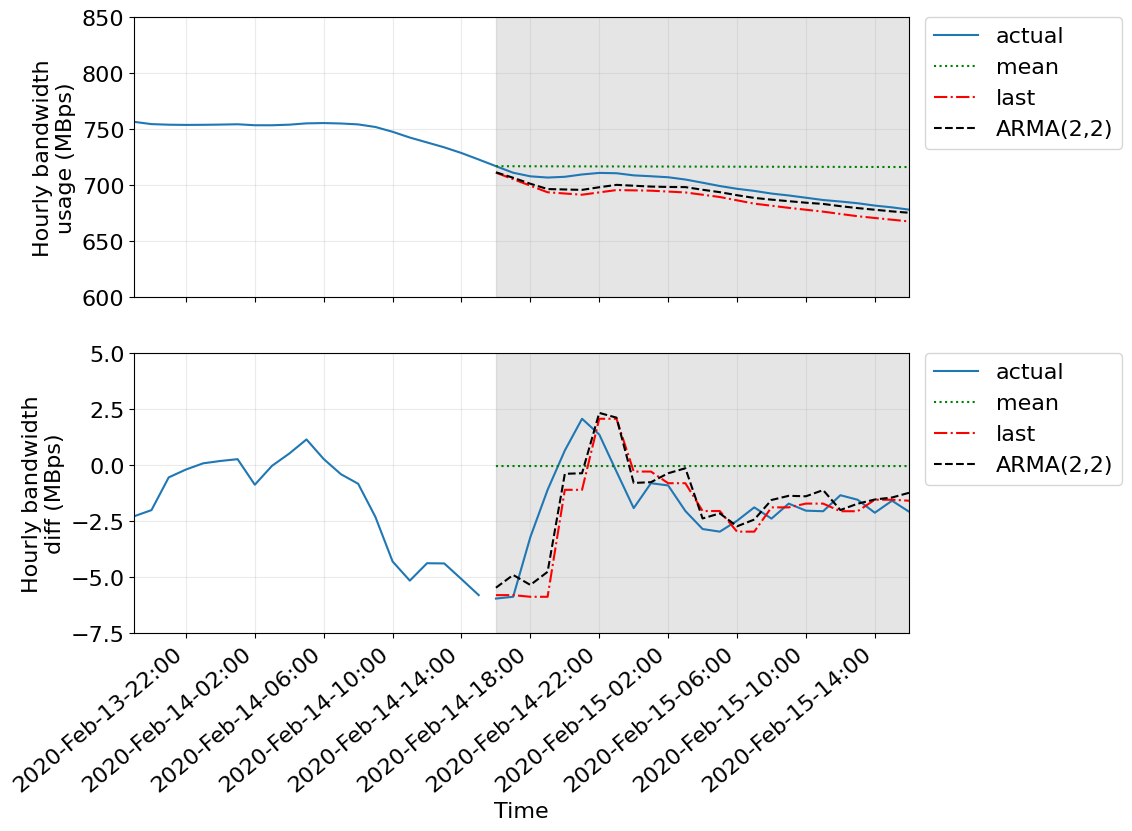

In [109]:
# Select you zoom-in area
start_idx = 9810  
stop_idx = 24     # two days
xlim = [df_train["date"].iloc[start_idx], df_test["date"].iloc[stop_idx]]
ylim_orig = [600, 850]
ylim_diff = [-7.5, 5]

fig, axes = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=(10, 8))

# -- first row
axes[0].plot(df_bandwidth['date'], df_bandwidth["hourly_bandwidth"], label="actual")
# -- prediction for the original data
axes[0].plot(df_test_bandwidth['date'], df_test_bandwidth["pred_mean"], "g:", label="mean")
axes[0].plot(df_test_bandwidth['date'], df_test_bandwidth["pred_last_value"], "r-.", label="last")
axes[0].plot(df_test_bandwidth['date'], df_test_bandwidth["pred_arma"], "k--", label="ARMA(2,2)")

formatter = mdates.DateFormatter("%Y-%b-%d-%H:00")
# locator = mdates.YearLocator(base=2)
# locator = mdates.MonthLocator(bymonthday=1, bymonth=range(1, 13, 1))
# locator = mdates.DayLocator()
locator = mdates.HourLocator(interval=4)
axes[0].xaxis.set_major_formatter(formatter)
axes[0].xaxis.set_major_locator(locator)
axes[0].set_ylim([500, 1000])
axes[0].grid("on")
axes[0].set_ylabel("Hourly bandwidth\nusage (MBps)")
axes[0].set_xlim(xlim)
axes[0].set_ylim(ylim_orig)
axes[0].legend(loc="upper left", bbox_to_anchor=[1.02, 1], borderaxespad=0.)

# -- second row
axes[1].plot(df_train["date"], df_train["bandwidth_diff"])
axes[1].plot(df_test["date"], df_test["bandwidth_diff"], color="tab:blue", label="actual")
# -- prediction
axes[1].plot(df_test_pred["date"], df_test_pred["pred_mean"], "g:", label="mean")
axes[1].plot(df_test_pred["date"], df_test_pred["pred_last_value"], "r-.", label="last")
axes[1].plot(df_test_pred["date"], df_test_pred["pred_arma"], "k--", label="ARMA(2,2)")

axes[1].set_xlabel("Time")
axes[1].set_ylabel("Hourly bandwidth\ndiff (MBps)")
axes[1].grid("on")
axes[1].set_ylim(ylim_diff)
axes[1].legend(loc="upper left", bbox_to_anchor=[1.02, 1], borderaxespad=0.)

# add forecast area
for j in range(2):
  axes[j].axvspan(df_test['date'].iloc[0], df_test['date'].iloc[-1], 
                  color="#808080", alpha=0.2)

for j, label in enumerate(axes[1].get_xticklabels()):
  label.set_rotation(40)
  label.set_horizontalalignment('right')


plt.show(fig)

In [110]:
mae_mean_undiff = mean_absolute_error(df_test_bandwidth["hourly_bandwidth"], df_test_bandwidth["pred_mean"])
mae_last_undiff = mean_absolute_error(df_test_bandwidth["hourly_bandwidth"], df_test_bandwidth["pred_last_value"])
mae_arma_undiff = mean_absolute_error(df_test_bandwidth["hourly_bandwidth"], df_test_bandwidth["pred_arma"])

print(f"MAE mean: {mae_mean_undiff}")
print(f"MAE last: {mae_last_undiff}")
print(f"MAE ARMA: {mae_arma_undiff}")

MAE mean: 40.587248973103954
MAE last: 14.440353127323633
MAE ARMA: 14.000362776708105


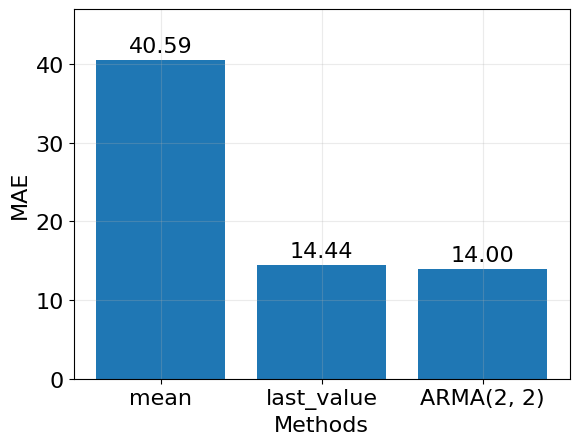

In [115]:
fig, ax = plt.subplots()

x_array = ["mean", "last_value", "ARMA(2, 2)"]
y_array = [mae_mean_undiff, mae_last_undiff, mae_arma_undiff]

ax.bar(x_array, y_array)
ax.grid("on")
ax.set_xlabel("Methods")
ax.set_ylabel("MAE")
ax.set_ylim([0, 47])

for idx, val in enumerate(y_array):
  ax.text(x=idx, y=val+1, s=f"{val:.2f}", ha="center")

plt.show(fig)

This returns an MAE for $\text{ARMA}(2,2)$ of 14, meaning that, on average, our forecast  
(for the next 2 hours) are 14 MBps above or below the actual bandwidth usage

## 6.7 Next steps

There is a way to model non-stationary time series without having to transform  
them and reverse the transformation on the predictions. Specifically, we can  
model _integrated_ time series using the _autoregressive integrated moving average_  
model or $\text{ARIMA}(p,d,q)$.

## Fix some bugs in data

Add date to `bandwidth.csv`. Frequency of the time is hourly.

In [15]:
file_path = "./datasets/bandwidth.csv" 
df_bandwidth_with_date = pd.read_csv(file_path)

df_bandwidth_with_date["date"] \
  = pd.date_range(start="2019-01-01", periods=len(df_bandwidth_with_date), freq="H")
df_bandwidth_with_date = df_bandwidth_with_date[["date", "hourly_bandwidth"]]

df_bandwidth_with_date.to_csv("./datasets/bandwidth_with_date.csv", index=False)

df_bandwidth_with_date

,date,hourly_bandwidth
0,2019-01-01 00:00:00,1000.496714
1,2019-01-01 01:00:00,1000.969408
2,2019-01-01 02:00:00,1002.046019
3,2019-01-01 03:00:00,1004.702118
4,2019-01-01 04:00:00,1007.447816
...,...,...
9995,2020-02-21 11:00:00,740.546059
9996,2020-02-21 12:00:00,738.906228
9997,2020-02-21 13:00:00,736.057995
9998,2020-02-21 14:00:00,733.559640
